In [1]:
# Loading packages.
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

In [2]:
# Loading the data.
df = pd.read_csv('C:/Users/maxsh/JupyterNoteBooks/Energy_consumption_work/Energy_consumption.csv')
df.head()
print(df.tail())

            Timestamp  Temperature   Humidity  SquareFootage  Occupancy  \
995  11/02/2022 11:00    28.619382  48.850160    1080.087000          5   
996  11/02/2022 12:00    23.836647  47.256436    1705.235156          4   
997  11/02/2022 13:00    23.005340  48.720501    1320.285281          6   
998  11/02/2022 14:00    25.138365  31.306459    1309.079719          3   
999  11/02/2022 15:00    23.051165  42.615421    1018.140606          6   

    HVACUsage LightingUsage  RenewableEnergy DayOfWeek Holiday  \
995       Off           Off        21.194696  Saturday      No   
996       Off            On        25.748176   Tuesday     Yes   
997       Off            On         0.297079    Friday     Yes   
998        On           Off        20.425163  Thursday     Yes   
999       Off            On         2.455657  Saturday      No   

     EnergyConsumption  
995          82.306692  
996          66.577320  
997          72.753471  
998          76.950389  
999          71.545311  


In [3]:
# Converting datetime format.
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format= '%d/%m/%Y %H:%M')
df = df[['Timestamp', 'EnergyConsumption']]

# Indexing 'Timestamp', as it becomes easier to perform time-based operations.
df.index = df['Timestamp']
del df['Timestamp']
print(df.head())

                     EnergyConsumption
Timestamp                             
2022-01-01 00:00:00          75.364373
2022-01-01 01:00:00          83.401855
2022-01-01 02:00:00          78.270888
2022-01-01 03:00:00          56.519850
2022-01-01 04:00:00          70.811732


Text(0, 0.5, 'Energy Consumption')

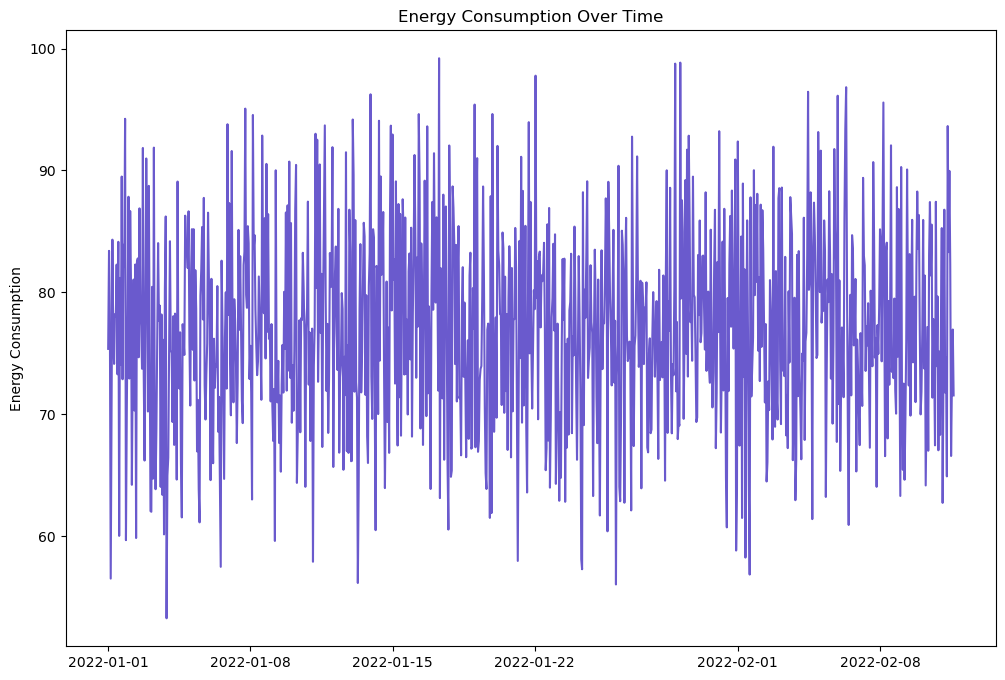

In [4]:
# Plotting Energy Consumption Over Time
plt.figure(figsize=(12, 8))

plt.plot(df, color = 'slateblue')
plt.title('Energy Consumption Over Time')
plt.ylabel('Energy Consumption')

# It is difficult to identify trends in this time series, although, there are regular spikes.

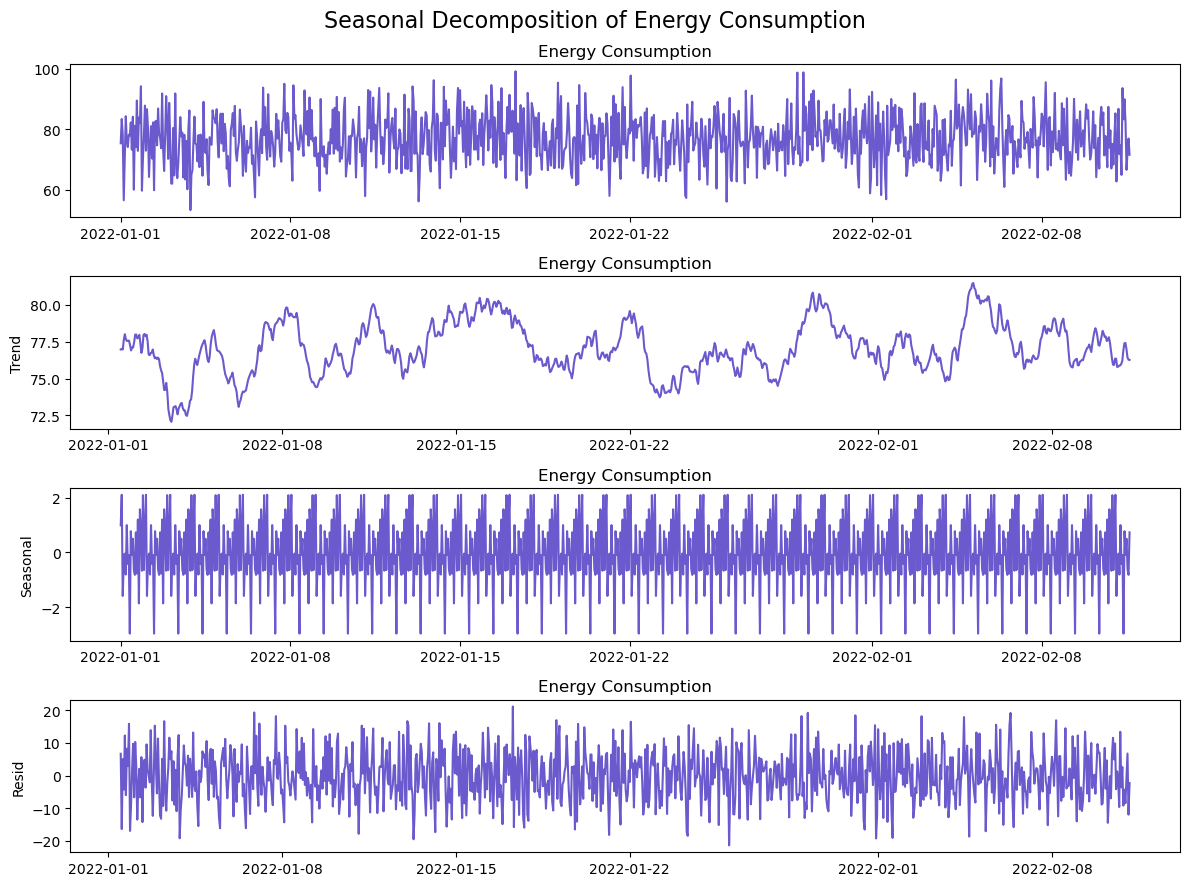

In [5]:
# Plotting Seasonal Decomposition of Energy Consumption

decompose = seasonal_decompose(df['EnergyConsumption'], model='additive')

plt.figure(figsize=(12, 9))

# Original time series
plt.subplot(411)
plt.plot(df['EnergyConsumption'], color = 'slateblue')
plt.title('Energy Consumption')

# Trend Component
plt.subplot(412)
plt.plot(decompose.trend, color = 'slateblue')
plt.title('Energy Consumption')
plt.ylabel('Trend')

# Seasonal Component
plt.subplot(413)
plt.plot(decompose.seasonal, color = 'slateblue')
plt.title('Energy Consumption')
plt.ylabel('Seasonal')

# Residual Component
plt.subplot(414)
plt.plot(decompose.resid, color = 'slateblue')
plt.title('Energy Consumption')
plt.ylabel('Resid')

# Title
plt.suptitle('Seasonal Decomposition of Energy Consumption', fontsize=16)

plt.tight_layout()
plt.show()

In [6]:
# The trend component appears to be volatile. This makes it difficult so see long-term patterns

# The seasonal component shows a very short period where the data is consistant then a repeating pattern occurs.
# These short periods could represent daily intervals in the data.

# Residual component is randomly distributed. No pattern in the data. This could indicate a good model fit.

In [7]:
# Rolling mean is the moving average. 
# This will allow me to smooth out variations in the data so that I can identifty trends.

rolling_mean = df['EnergyConsumption'].rolling(10).mean()
rolling_std = df['EnergyConsumption'].rolling(10).std()
rolling_mean
rolling_std

Timestamp
2022-01-01 00:00:00          NaN
2022-01-01 01:00:00          NaN
2022-01-01 02:00:00          NaN
2022-01-01 03:00:00          NaN
2022-01-01 04:00:00          NaN
                         ...    
2022-02-11 11:00:00    10.456468
2022-02-11 12:00:00     9.871646
2022-02-11 13:00:00     9.925414
2022-02-11 14:00:00     9.510363
2022-02-11 15:00:00     9.526529
Name: EnergyConsumption, Length: 1000, dtype: float64

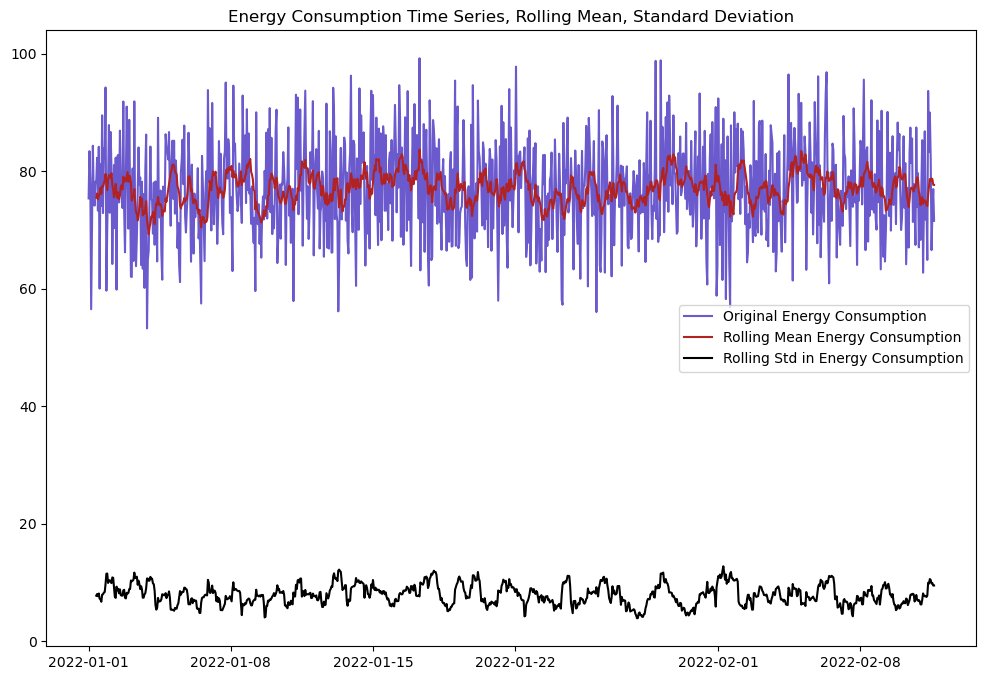

In [8]:
# Creating a plot showing the Energy Consumption Time Series Including th Rolling Mean and Standard Deviation.
# The rolling mean line makes it easier to spot patterns 

plt.figure(figsize=(12, 8))
plt.plot(df, color="slateblue",label="Original Energy Consumption")
plt.plot(rolling_mean, color="firebrick", label="Rolling Mean Energy Consumption")
plt.plot(rolling_std, color="black", label = "Rolling Std in Energy Consumption")
plt.title("Energy Consumption Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

In [9]:
# Augmented Dickey Fuller test (ADF Test)
# Null hypothesis is that the time series is non-stationary.
# This test will provide us with evidence for or against the null hypothesis.

from statsmodels.tsa.stattools import adfuller
adft = adfuller(df,autolag="AIC")

In [10]:
adft_results = [adft[0], adft[1], adft[2], adft[3]]
output_df = pd.DataFrame({"Values": adft_results, "Metric": ["Test Statistics", "p-value", "No. of lags used", "Number of observations used"]})
print(output_df)

       Values                       Metric
0  -31.576934              Test Statistics
1    0.000000                      p-value
2    0.000000             No. of lags used
3  999.000000  Number of observations used


In [11]:
# The p-value is less than the significance level (0.05), which indicates that we reject the null hypothesis.  
# As a result, the time series is stationary. 
# This means that the properties of the time series, such as mean and variance, remain constant across all time periods. 
# The stationary time series simplifies the modeling process and makes forecasting more predictable.

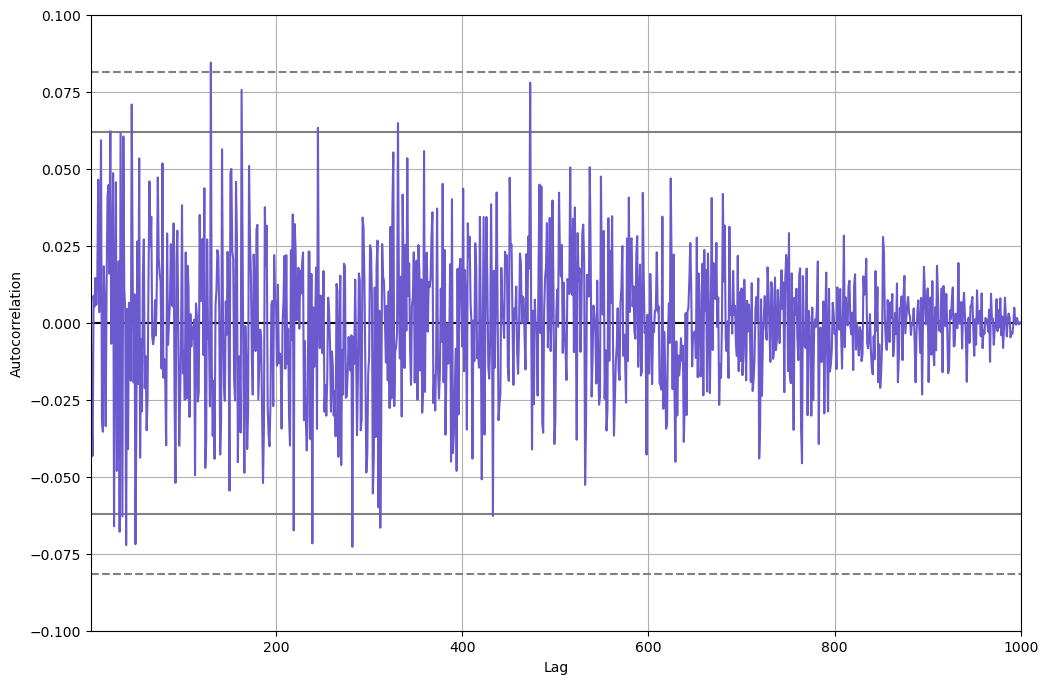

In [12]:
# Autocorrelation 

from pandas.plotting import autocorrelation_plot

# plot
plt.figure(figsize=(12, 8))
autocorrelation_plot(df['EnergyConsumption'], color = 'slateblue')
plt.ylim(-0.1, 0.1)
plt.show()

# Only one point lies above the dashed line, indicating statistical significance from 0. 
# Autocorrelation coefficients exhibit no patterns with past values and are close to 0 at all lags. 
# There are spikes at regular intervals indicating seasonality.

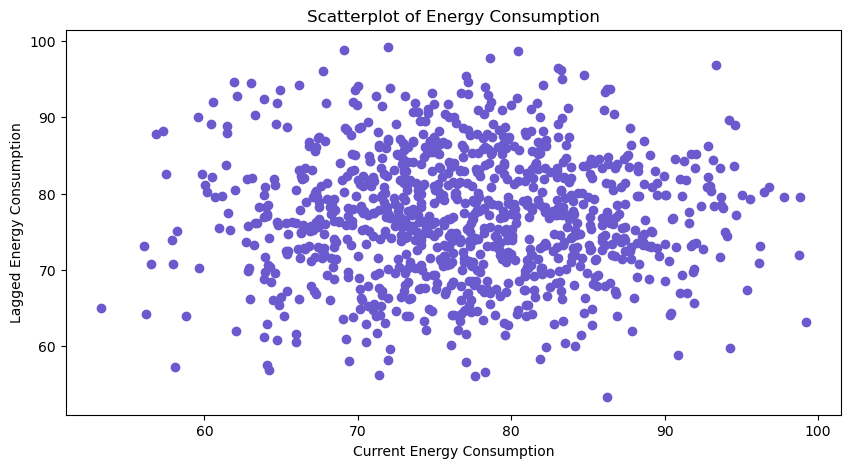

In [13]:
# Plotting lag plots for Energy Consumption 
plt.figure(dpi=100, figsize=(10, 5))
pd.plotting.lag_plot(df['EnergyConsumption'], c='slateblue')
plt.title('Scatterplot of Energy Consumption')
plt.xlabel('Current Energy Consumption')
plt.ylabel('Lagged Energy Consumption')
plt.show()

In [14]:
# There is no noticeable pattern in the lag plot. The data appears to be random white noise.

In [15]:
# Forecasting.

# The Autocorrelation indicated seasonality in the data. 
# Therefore, SARIMAX would be an appropriate model for forecasting.

# Automated ARIMA model will perform a step wise search and find the best model. 

import pmdarima as pm

# Auto_arima model 
# I have set m = 24 to represent each day
model1 = pm.auto_arima(df, seasonal=True, m=24, 
                       d=0, D=1, 
                       max_p=2, max_q=2, 
                       trace=True, 
                       error_action='ignore', 
                       suppress_warnings=True)


# Print model summary
print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[24] intercept   : AIC=inf, Time=31.69 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=7532.597, Time=0.27 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=7267.694, Time=4.75 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=10.24 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=7530.599, Time=0.17 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=7534.296, Time=0.66 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=7155.155, Time=13.45 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=41.29 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=13.56 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=7153.160, Time=9.67 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=7266.406, Time=2.43 sec
 ARIMA(0,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=30.45 sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=10.86 sec
 ARIMA(0,0,1)(2,1,0)[24] intercept   : AIC=7155.154, Time=11.61 sec
 ARIMA(1,0,1)(2,1,0)[24] intercept   : AI

In [16]:
# I found that ARIMA(0,0,0)(2,1,0)[24] is the best model.
# Therefore, I will use this order in my SARIMAX model.

from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# Creating the SARIMAX model
model = SARIMAX(df, order=(0, 0, 0), seasonal_order=(2, 1, 0, 24))

# Fit the model
results = model.fit()

# Results Summary
print(results.summary())

                                SARIMAX Results                                 
Dep. Variable:        EnergyConsumption   No. Observations:                 1000
Model:             SARIMAX(2, 1, 0, 24)   Log Likelihood               -3572.582
Date:                  Thu, 01 Feb 2024   AIC                           7151.163
Time:                          19:17:18   BIC                           7165.814
Sample:                      01-01-2022   HQIC                          7156.738
                           - 02-11-2022                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24      -0.6661      0.030    -21.859      0.000      -0.726      -0.606
ar.S.L48      -0.3434      0.030    -11.531      0.000      -0.402      -0.285
sigma2        87.3464      4.166    

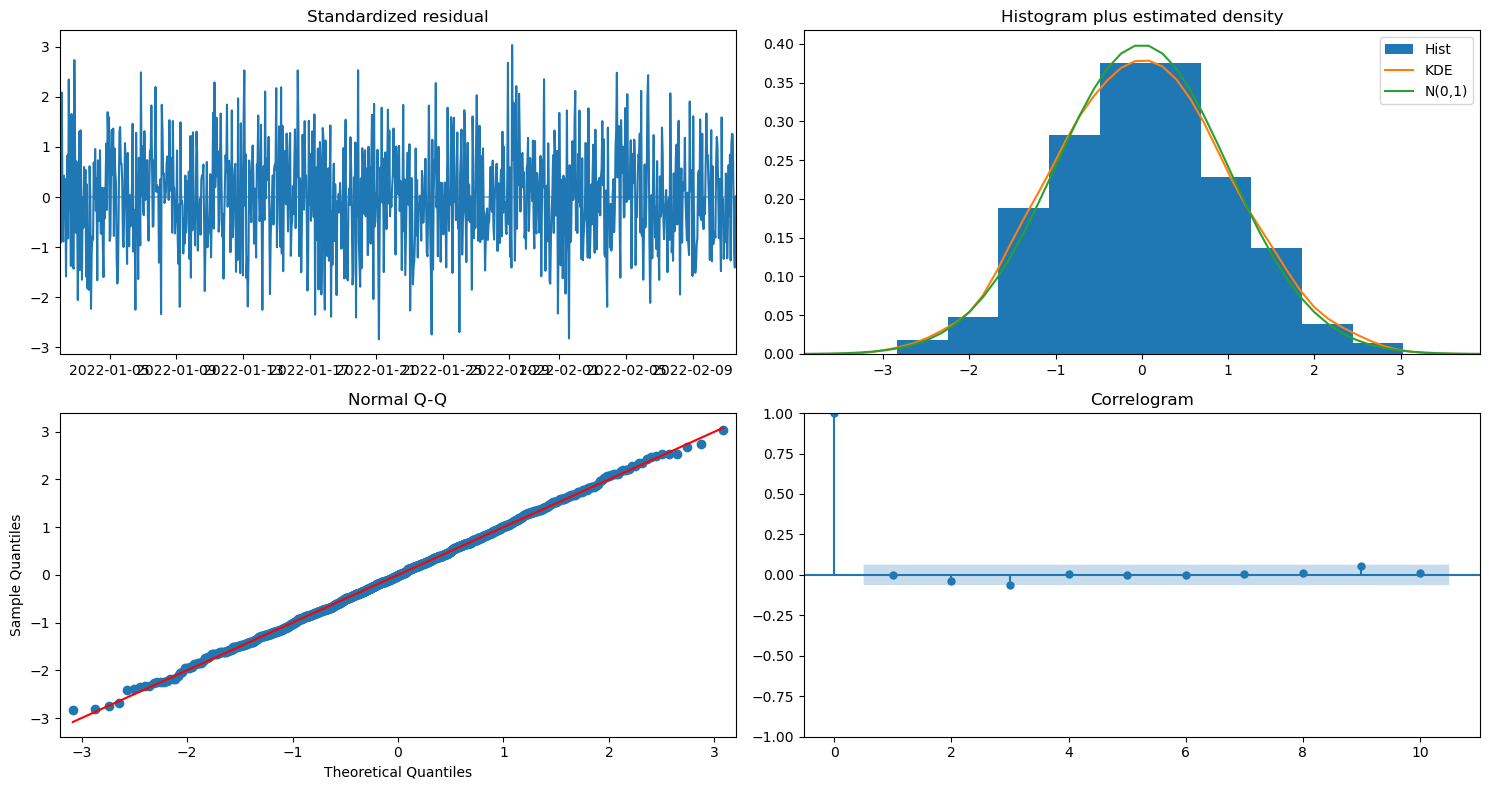

In [19]:
model1.plot_diagnostics(figsize=(15, 8))
plt.tight_layout()
plt.show()

# By checking the diagnostics 
# I can confirm that a ARIMA(0,0,0)(2,1,0)[7] model was a good fit for the Energy Consumption Time Series

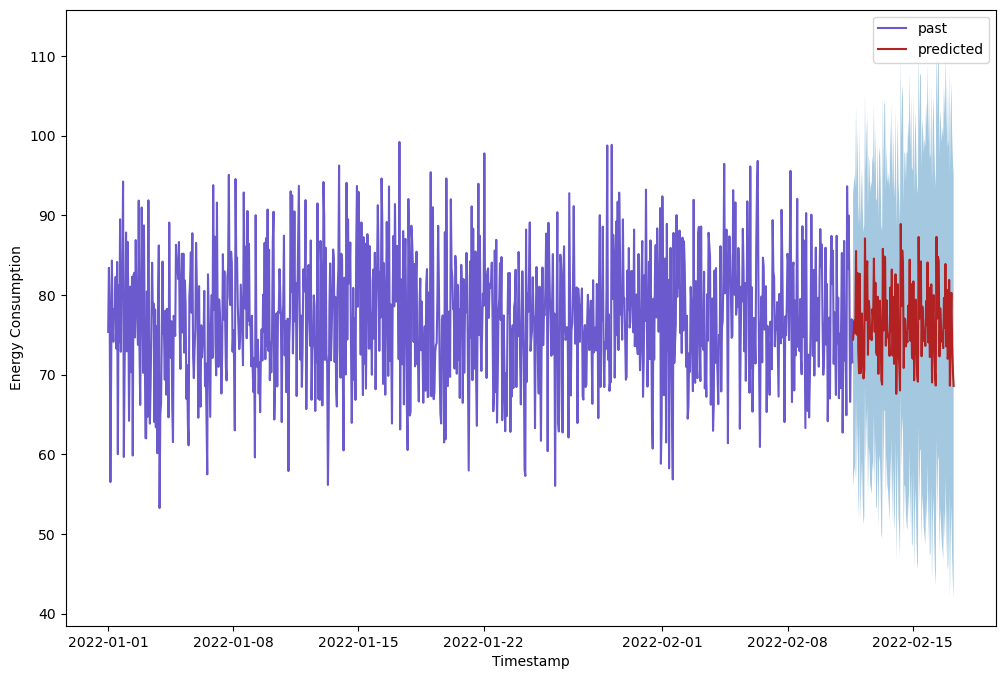

In [17]:
forecast_object = results.get_forecast(136)

# Predicted mean 
mean = forecast_object.predicted_mean

# Confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Energy Consumption levels
plt.plot(df.index, df['EnergyConsumption'], label='past', color = 'slateblue')

# Prediction means as a line
plt.plot(dates, mean, label='predicted', color = 'firebrick')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], alpha=0.4)

plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()

plt.show()

# The blue line shows the past energy consumption data.

# The red line represent the models estimation of the expected trend in energy consumption

# The shaded area represents the confidence intervals. The wider it gets the more uncertainty there is in the prediction
# The area looks wide suggesting higher uncertainty. 

In [20]:
# This is the predicted mean at the timestamp '2022-02-17 07:00:00'.

print(mean.iloc[-1])


# The confidence interval is expected the actual value to fall between 42.00 and 95.15.

print(conf_int.iloc[-1])

68.57632190697366
lower EnergyConsumption    42.004527
upper EnergyConsumption    95.148117
Name: 2022-02-17 07:00:00, dtype: float64
